# Latent semantic analysis

Create term-document matrix $A$, make SVD $A=USV^T$, use projections of #A# columns on first $n$ columns of $U$ as document vectors. Classify documents with logistic regression on these vectors. One can also consider $A$ rows projections on columns of $V$, i.e. $A\cdot V$, as word vectors.

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

import nltk
nltk.download("stopwords")
stopwords = set(nltk.corpus.stopwords.words("russian"))

import json

from IPython.display import display, HTML

import winsound

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load direct and inverted indices
import sys
if '..' not in sys.path:
    sys.path.append('..')
from src.utils import LoadIndices, LoadDatasets, TrainTestIdx, Beep

# Load datasets
an_jokes, bash_jokes = LoadDatasets()
# Load direct and inverted indices
an_direct, an_inverted, bash_direct, bash_inverted = LoadIndices()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Term-document matrices

There several ways to create term-document matrix. It can be binary matrix or matrix with number of word use. We can also apply different mormalizations, add regularizers, take log and so on.

In [142]:
def num_of_use(word, inverted_index):
    return len(inverted_index[word][0] + inverted_index[word][1])

def word_to_index(inverted_index):
    # List of words which are used in more than 1 joke
    i2w = [w for w in inverted_index if num_of_use(w, inverted_index) > 1 and w not in stopwords]
    # Word to index map
    w2i = {w: i for i, w in enumerate(i2w)}
    return i2w, w2i
    
def term_document_1(direct_index, inverted_index, mean_sub = False):
    """Binary matrix"""
    i2w, w2i = word_to_index(inverted_index)
    num_of_words = len(i2w)  # Number of words which are used in more than 1 joke
    num_of_docs = len(direct_index)
    A = np.zeros((num_of_words, num_of_docs), dtype = np.int8)
    for j, d in enumerate(direct_index):
        for w in d:
            if w in w2i:
                i = w2i[w]
                A[i,j] = 1
    if mean_sub:
        for i in range(num_of_words):
            A[i,:] -= np.mean(A[i,:])
    return A    

def term_document_2(direct_index, inverted_index, mean_sub = False):
    """Number of word use matrix"""
    i2w, w2i = word_to_index(inverted_index)
    num_of_words = len(i2w)
    num_of_docs = len(direct_index)
    A = np.zeros((num_of_words, num_of_docs))
    for j, d in enumerate(direct_index):
        for w in d:
            if w in w2i:
                i = w2i[w]
                A[i,j] = d[w]
    if mean_sub:
        for i in range(num_of_words):
            A[i,:] -= np.mean(A[i,:])
    return A

def term_document_tfidf(direct_index, inverted_index, mean_sub = False):
    A = term_document_2(direct_index, inverted_index)
    # tf-idf
    r = np.sum(A, axis = 1)  # Num of word use
    #r = np.sum((A > 0).astype('int'), axis = 1)  # Num of doc with given word
    c = np.sum(A, axis = 0)  # Num of words in given document
    for j in range(A.shape[1]):
        if c[j] > 0:
            A[:,j] /= c[j]  # tf
    for i in range(A.shape[0]):
        A[i,:] *= np.log(A.shape[1] / r[i])
    if mean_sub:
        for i in range(A.shape[0]):
            A[i,:] -= np.mean(A[i,:])
    
    return A

In [170]:
def LSA_vectors(direct_index, inverted_index, dim = 50, show_singular_values = True, mean_sub = False):
    ''' SVD of term-document matrix '''
    A = term_document_tfidf(direct_index, inverted_index, mean_sub)
    tsvd = TruncatedSVD(n_components = dim)
    tsvd.fit(A)
    # Word vectors
    US = tsvd.transform(A)
    i2w, w2i = word_to_index(inverted_index)
    word_vectors = {i2w[i] : US[i,:] for i in range(US.shape[0])}
    # Doc vectors
    s = tsvd.singular_values_
    U = US.copy()
    for i in range(dim):
        U[:,i] /= s[i]
    doc_vectors = np.dot(A.T, U)

    if show_singular_values:
        plt.figure()
        plt.plot(np.log(s), '.-')
    
    return word_vectors, doc_vectors

Wall time: 2min 10s


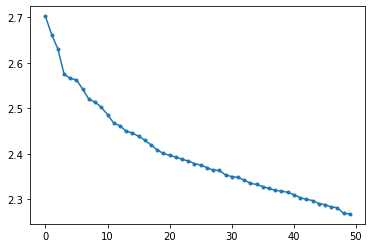

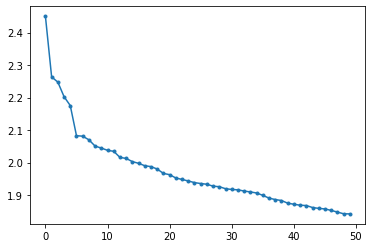

In [171]:
%%time
# ~2 min is expected

an_word_vectors, an_doc_vectors = LSA_vectors(an_direct, an_inverted, dim = 50, mean_sub = True)
bash_word_vectors, bash_doc_vectors = LSA_vectors(bash_direct, bash_inverted, dim = 50, mean_sub = True)

# Save vectors
# 1. Transform data to json serializable format
def matrix_to_list(A):
    return [list(row) for row in A]
def arrays_to_list(D):
    return {w: list(D[w]) for w in D}
data = {'anec': (arrays_to_list(an_word_vectors), matrix_to_list(an_doc_vectors)),
        'bash': (arrays_to_list(bash_word_vectors), matrix_to_list(bash_doc_vectors))
       }
# 2. save
f = open('..\\data\\interim\\trained_vectors\\lsa2_3.json', 'w', encoding = 'utf-8')
f.write(json.dumps(data, ensure_ascii = False))
f.close()

winsound.Beep(500, 1000)

In [4]:
# Load vectors
data = json.loads(open('..\\data\\interim\\trained_vectors\\lsa2_3.json', 'r', encoding = 'utf-8').read())

an_word_vectors = data['anec'][0]
an_doc_vectors = np.array(data['anec'][1])
bash_word_vectors = data['bash'][0]
bash_doc_vectors = np.array(data['bash'][1])

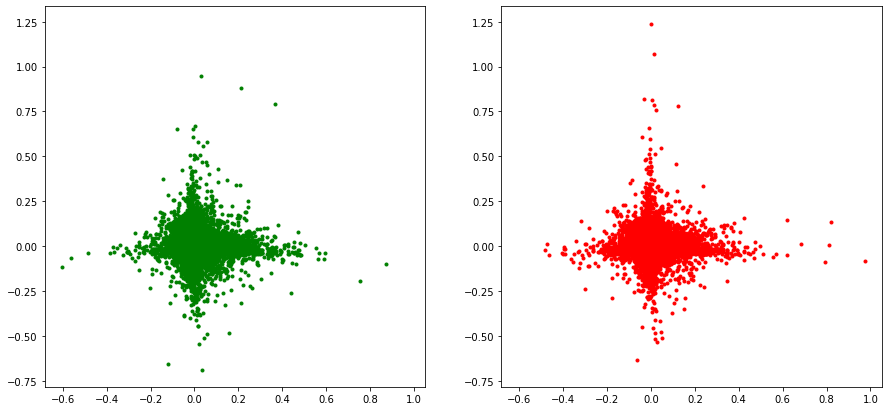

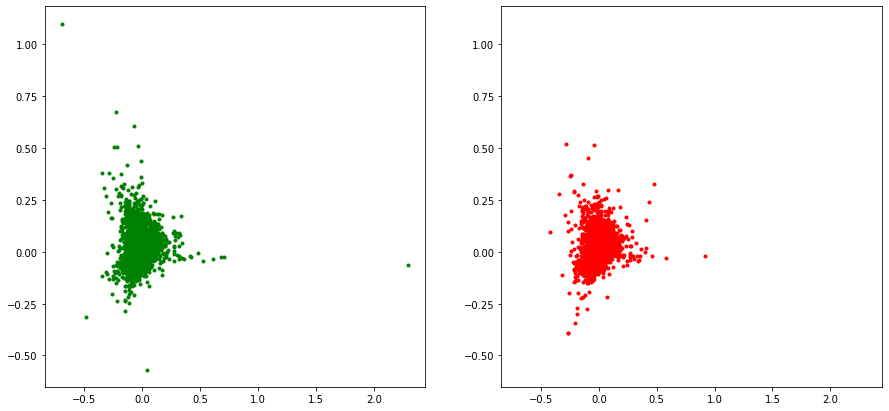

In [112]:
i1, i2 = 6,14
is_good = np.array([d[-1] for d in an_jokes])
plt.figure(figsize = (15,7))
ax1 = plt.subplot(1,2,1)
plt.plot(an_doc_vectors[is_good == 1, i1], an_doc_vectors[is_good == 1, i2], '.', c = 'green')
plt.subplot(1,2,2, sharex = ax1, sharey = ax1)
plt.plot(an_doc_vectors[is_good == 0, i1], an_doc_vectors[is_good == 0, i2], '.', c = 'red')

is_good = np.array([d[-1] for d in bash_jokes])
plt.figure(figsize = (15,7))
ax1 = plt.subplot(1,2,1)
plt.plot(bash_doc_vectors[is_good == 1, i1], bash_doc_vectors[is_good == 1, i2], '.', c = 'green')
plt.subplot(1,2,2, sharex = ax1, sharey = ax1)
plt.plot(bash_doc_vectors[is_good == 0, i1], bash_doc_vectors[is_good == 0, i2], '.', c = 'red')

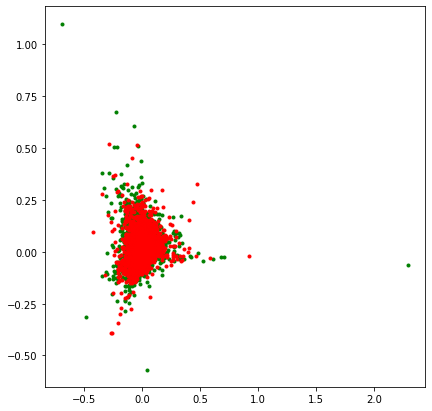

In [114]:
is_good = np.array([d[-1] for d in bash_jokes])
plt.figure(figsize = (15,7))
ax1 = plt.subplot(1,2,1)
plt.plot(bash_doc_vectors[is_good == 1, i1], bash_doc_vectors[is_good == 1, i2], '.', c = 'green')
# plt.xlim(-0.03, 0.03)
# plt.ylim(-0.45, 0.9)
# ax1 = plt.subplot(1,2,2, sharex = ax1)
plt.plot(bash_doc_vectors[is_good == 0, i1], bash_doc_vectors[is_good == 0, i2], '.', c = 'red')

## Classification with logistic regression

In [7]:
def logistic_regression_model(jokes, doc_vectors):
    train_idx, test_idx = TrainTestIdx(jokes)
    X = doc_vectors.copy()
    y = np.array(np.array([d[-1] for d in jokes]))

    X_train = X[train_idx,:]
    y_train = y[train_idx]
    X_test = X[test_idx,:]
    y_test = y[test_idx]

    lr = LogisticRegression(penalty = 'none')
    lr.fit(X_train, y_train)
    print("Train accuracy: {:.3f}".format(lr.score(X_train, y_train)))
    print("Test accuracy: {:.3f}".format(lr.score(X_test, y_test)))
    
    return lr

def components_significance(lr_model, X):
    coef = np.squeeze(lr_model.coef_)
    dim = len(coef)
    s = np.zeros(dim)
    for i in range(dim):
        s[i] = np.dot(X[:,i],X[:,i])
    sig = np.abs(s * coef)
    idx = np.argsort(sig)[::-1]

    print("Top 5 components:", idx[:5])

    plt.plot(sig, '.-')
    return idx

### Anecdotes

In [8]:
an_lr = logistic_regression_model(an_jokes, an_doc_vectors)

Train accuracy: 0.585
Test accuracy: 0.587


Top 5 components: [ 0  6 19 18  7]


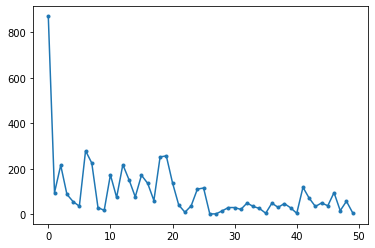

In [10]:
an_idx = components_significance(an_lr, an_doc_vectors)

### Bash quotes

In [12]:
bash_lr = logistic_regression_model(bash_jokes, bash_doc_vectors)

Train accuracy: 0.602
Test accuracy: 0.588


Top 5 components: [ 3  6  1 14  2]


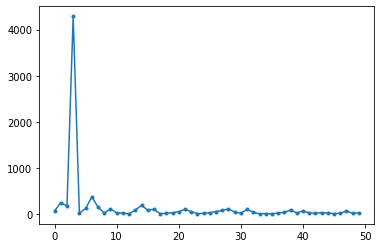

In [13]:
bash_idx = components_significance(bash_lr, bash_doc_vectors)

## kNN classification

In [14]:
def knn_classifier(jokes, doc_vectors, components, n_neigh = 5):
    train_idx, test_idx = TrainTestIdx(jokes)
    X = doc_vectors[:,components].copy()
    y = np.array(np.array([d[-1] for d in jokes]))

    X_train = X[train_idx,:]
    y_train = y[train_idx]
    X_test = X[test_idx,:]
    y_test = y[test_idx]

    neigh = KNeighborsClassifier(n_neighbors = n_neigh)
    neigh.fit(X_train, y_train)
    acc_train = neigh.score(X_train, y_train)
    acc_test = neigh.score(X_test, y_test)
    print("Train accuracy: {:.3f}".format(acc_train))
    print("Test accuracy: {:.3f}".format(acc_test))
    
    return neigh, acc_train, acc_test

### Anecdotes

In [15]:
%%time
# ~4 min for dim = 50 is expected 

X = an_doc_vectors.copy()
dim = X.shape[1]
s = np.zeros(dim)
for i in range(dim):
    s[i] = np.dot(X[:,i],X[:,i])
    X[:,i] /= s[i]


neigh, acc_train, acc_test = knn_classifier(an_jokes, X, components = an_idx[:10], n_neigh = 20)

winsound.Beep(500, 1000)

Train accuracy: 0.620
Test accuracy: 0.561
Wall time: 12.7 s


### Bash quotes

In [16]:
%%time
# ~3 min for dim = 50 is expected

X = bash_doc_vectors.copy()
dim = X.shape[1]
s = np.zeros(dim)
for i in range(dim):
    s[i] = np.dot(X[:,i],X[:,i])
    X[:,i] /= s[i]


neigh, acc_train, acc_test = knn_classifier(bash_jokes, X, components = bash_idx[:10], n_neigh = 20)

winsound.Beep(500, 1000)

Train accuracy: 0.627
Test accuracy: 0.569
Wall time: 7.84 s


## Random forest

In [107]:
def rf_classifier(jokes, doc_vectors):
    train_idx, test_idx = TrainTestIdx(jokes)
    X = doc_vectors.copy()
    y = np.array(np.array([d[-1] for d in jokes]))

    X_train = X[train_idx,:]
    y_train = y[train_idx]
    X_test = X[test_idx,:]
    y_test = y[test_idx]

    model = xgb.XGBRFClassifier(max_depth = 3, learning_rate = 0.1, n_jobs = 8, colsample_bytree = 0.3, \
                                n_estimators = 100)
    model.fit(X_train, y_train)
    acc_train = model.score(X_train, y_train)
    acc_test = model.score(X_test, y_test)
    print("Train accuracy: {:.3f}".format(acc_train))
    print("Test accuracy: {:.3f}".format(acc_test))
    
    fig, ax = plt.subplots(figsize = (15,15))
    xgb.plot_importance(model, ax = ax)
#     plt.rcParams["figure.figsize"] = [25,5]
    


### Anecdotes

Train accuracy: 0.588
Test accuracy: 0.580
Wall time: 1.38 s


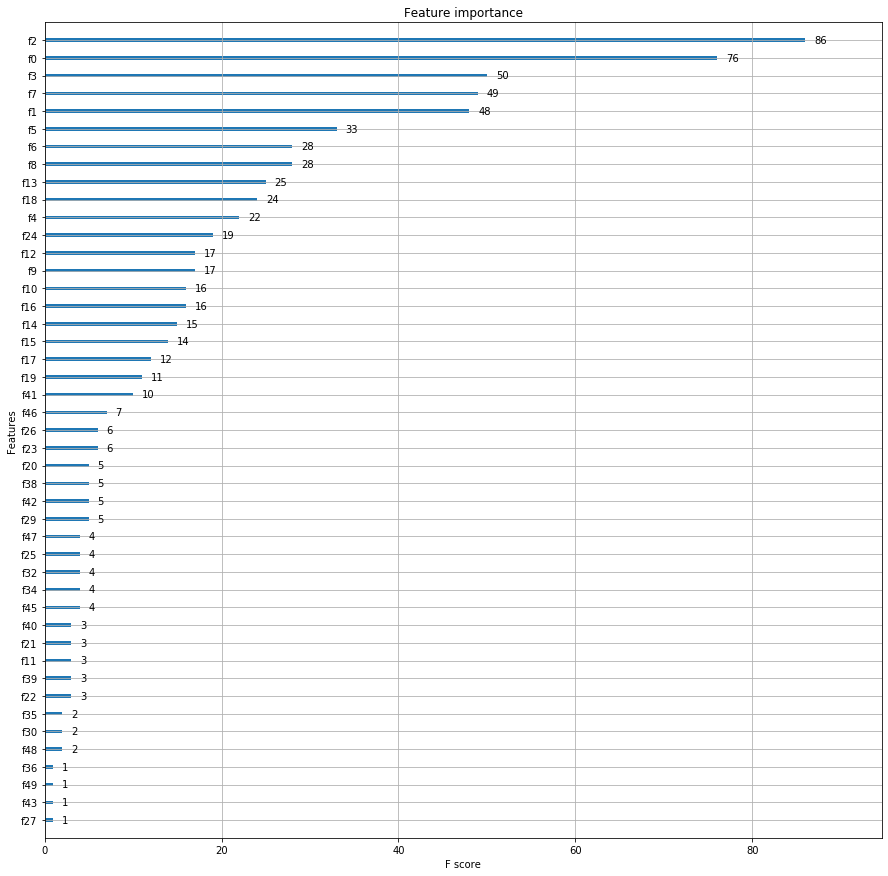

In [108]:
%%time

rf_classifier(an_jokes, an_doc_vectors)

### Bash quotes

Train accuracy: 0.598
Test accuracy: 0.573
Wall time: 833 ms


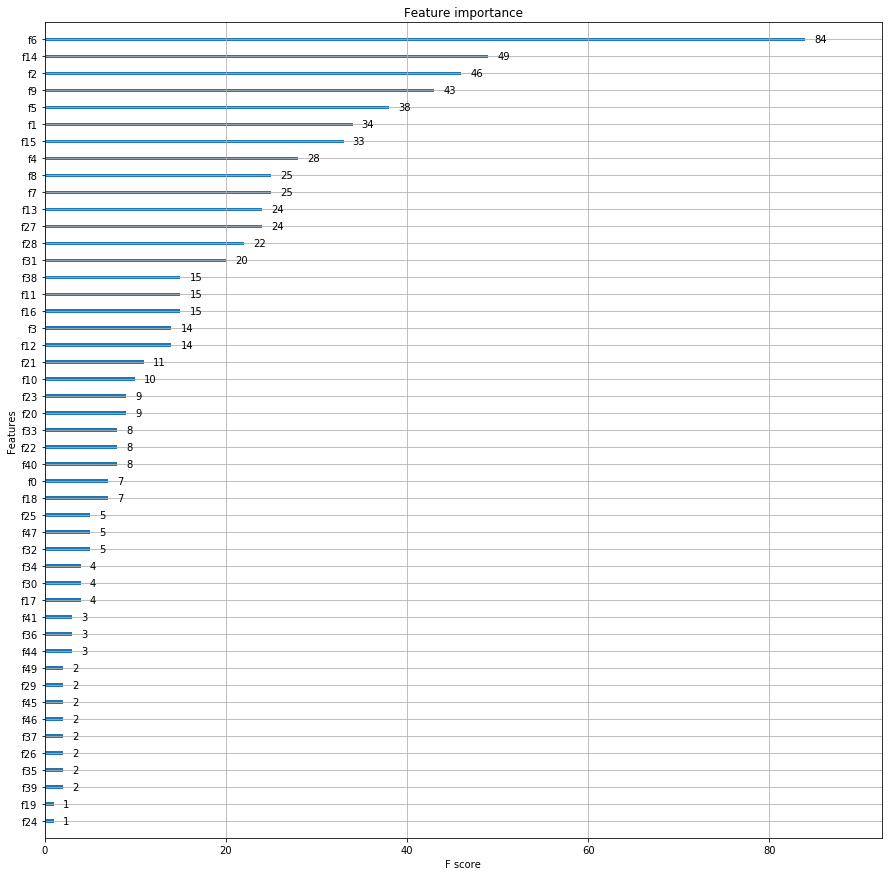

In [109]:
%%time

rf_classifier(bash_jokes, bash_doc_vectors)

## Components interpretation

### Words most correlated with some component

In [124]:
def component_words(components, word_vectors, inverted_index, n_words, min_use = 10):
    df = pd.DataFrame()
    for c in components:
        words = []
        corrs = []
        for word in inverted_index:
            if word in word_vectors and len(inverted_index[word][0]) + len(inverted_index[word][1]) >= min_use:
                corr = word_vectors[word][c] / np.linalg.norm(word_vectors[word])
                corrs.append(corr)
                words.append(word)
        idx = np.argsort(corrs)[::-1]
        words = [words[i] for i in idx[:n_words]]
        df['comp'+str(c)] = words
    display(HTML(df.to_html()))
    return df
    
    
components = [1,2,3,4,5]
n_words = 20
an_comp = component_words(components, an_word_vectors, an_inverted, n_words)


,comp1,comp2,comp3,comp4,comp5
0,—,женщина,местность,гудеть,любить
1,удалиться,соцопрос,бонд,пересечь,донецк
2,гигант,засада,девушка,подвезти,лука
3,ослик,обладать,пощупать,запить,грубый
4,отвёртка,обманывать,чеснок,чеснок,бездомный
5,подрезать,тайна,парень,пощупать,назло
6,прочь,снятие,пересечь,парень,теребить
7,почитай,несомненно,шест,вываливаться,повторяться
8,разрушать,умыться,пугаться,девушка,кусаться
9,наркоз,резиновый,юноша,шест,слеза
